# **Cyclists Outlier Detection**

Outlier detection is conducted on engineered features prior to clustering to enhance the analysis and improve clustering performance, as many algorithms are sensitive to outliers. Outlier detection is performed only on features that will be used in clustering analysis.

The approach in this analysis involves detecting outliers using three different methods that capture various aspects of the data, followed by a majority vote to determine whether a data point is an outlier, in an ensemble fashion.

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Read the dataset from a CSV file and fix columns to keep
cyclists_df = pd.read_csv('../dataset/cyclists_clustering.csv')
                   
columns_to_keep = ["avg_relative_position", "mean_sq", "career_level"]

cluster_0_drop = list(set(cyclists_df.select_dtypes(include=[np.number]).columns) - set(columns_to_keep))

# Store a copy of the dataframe to keep the original data
cyclists_with_outlier_score = cyclists_df.copy()

# keep only selected features and scale them
cyclists_df = cyclists_df.select_dtypes(include=[np.number])
cyclists_df = cyclists_df.drop(columns=cluster_0_drop)
cyclist_numeric_columns = cyclists_df.columns.to_list()

scaler = MinMaxScaler()
cyclists_df = pd.DataFrame(scaler.fit_transform(cyclists_df), columns=cyclists_df.columns)

cyclists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3546 entries, 0 to 3545
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   avg_relative_position  3546 non-null   float64
 1   career_level           3546 non-null   float64
 2   mean_sq                3546 non-null   float64
dtypes: float64(3)
memory usage: 83.2 KB


## Connectivity approach


The connectivity approach identifies outliers by measuring the distance between data points and their neighbors, considering points with fewer neighbors or greater distances as outliers.

In [56]:
from sklearn.neighbors import LocalOutlierFactor

k = 15

algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(cyclists_df)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
cyclists_with_outlier_score.loc[:, "lof_degree"] = outlier_degrees

Plot the lof degree to understand where to put a threshold to avoid too much or too few outliers

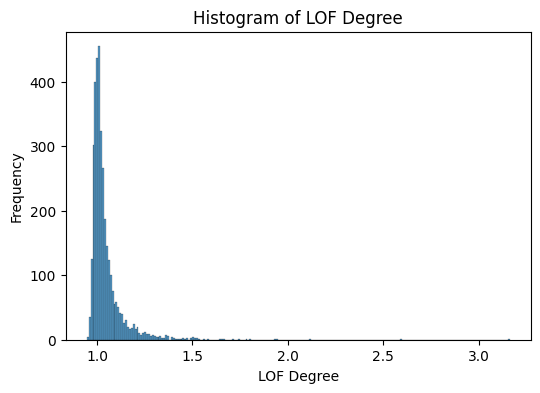

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  
sns.histplot(outlier_degrees, binwidth=0.01)
plt.xlabel('LOF Degree')
plt.ylabel('Frequency')
plt.title('Histogram of LOF Degree')
plt.show()

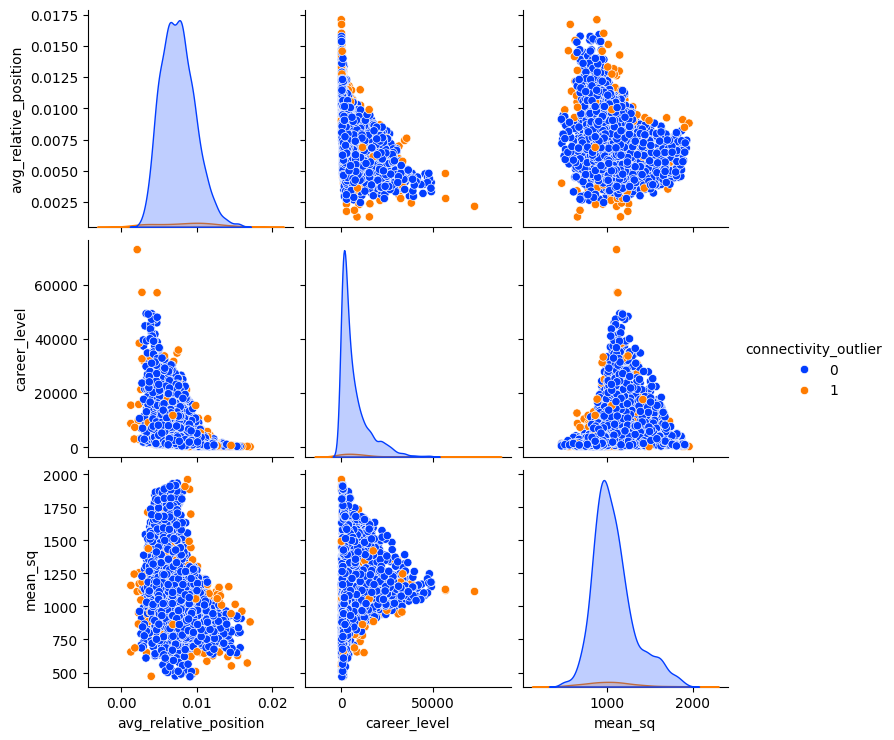

In [58]:
# fic threashold and classify outliers
threshold = 1.25    # 1.4 for less outliers

# Threshold and map to {0: inlier, 1: outlier}
cyclists_with_outlier_score['connectivity_outlier'] = (cyclists_with_outlier_score['lof_degree'] > threshold).astype(int)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ['connectivity_outlier']], hue='connectivity_outlier', diag_kind='kde', palette='bright')
plt.show()

Counting outliers identified by the method

In [59]:
cyclists_with_outlier_score["connectivity_outlier"].value_counts()

connectivity_outlier
0    3426
1     120
Name: count, dtype: int64

Analyze some of them

In [60]:
outliers = cyclists_with_outlier_score[cyclists_with_outlier_score['connectivity_outlier'] == 1]
outliers.drop(columns="connectivity_outlier").head()

,_url,name,birth_year,nationality,cyclist_experience,cyclist_experience_points,cyclist_win,cyclist_win_ratio,avg_relative_position,relative_position_std,...,performance_entropy,weighted_podiums,career_level,avg_position,best_position,position_std,mean_sq,top_cyclists,top_experience,lof_degree
48,gert-steegmans,Gert Steegmans,1980,Belgium,303,23293.0,4,0.013201,0.010132,0.006899,...,5.474493,1.122112,8167.723707,100.973597,0,50.822369,1045.656766,Top 1300,Top 750,1.261018
67,tadej-pogacar,Tadej Pogačar,1998,Slovenia,166,17775.0,30,0.180723,0.001311,0.001727,...,4.486316,30.903614,15475.414930,14.313253,0,18.713423,1158.957831,Top 500,Top 1300,1.943948
105,matteo-bono,Matteo Bono,1983,Italy,485,36911.0,2,0.004124,0.011481,0.006099,...,6.044959,0.206186,10477.341335,114.641237,0,36.514335,1100.049485,Top 1000,Top 500,1.930639
142,james-knox,James Knox,1995,Great Britain,231,16480.0,0,0.000000,0.007373,0.005131,...,5.197535,0.194805,8844.128230,69.961039,1,44.526331,815.277056,Top 1000,Top 1000,1.255414
178,jens-mouris,Jens Mouris,1980,Netherlands,88,6810.0,0,0.000000,0.012608,0.006875,...,4.320522,0.000000,1451.318932,127.738636,3,44.784412,1111.727273,Top 3000,Top 2000,1.366108


## One-class SVM


One-Class SVM identifies outliers by learning a boundary around the majority of the data points, classifying points outside this boundary as outliers. The number of outliers is set to 3% of the dataset using the **nu** parameter, ensuring the outlier count is of a similar magnitude to that of other methods.

In [61]:
from sklearn.svm import OneClassSVM


kernel = "rbf"      # "linear", "poly", "rbf", "sigmoid"
algorithm = OneClassSVM(kernel=kernel, nu=0.03)
algorithm.fit(cyclists_df)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(cyclists_df)
outlier_distance_scores = algorithm.score_samples(cyclists_df)

cyclists_with_outlier_score.loc[:, "svm_degree"] = outlier_distance_scores
# map to {0: inliers, 1: outliers}
cyclists_with_outlier_score.loc[:, "svm_outlier"] = -(outlier_classification_scores  - 1) / 2  

if kernel == "linear":
    support_vectors = cyclists_df.iloc[algorithm.support_]
    
else:
    support_vectors = None

All of the kernel where tested, visually rbf seems to be the best in eliminating out of distribution values, given the "shape" of the data

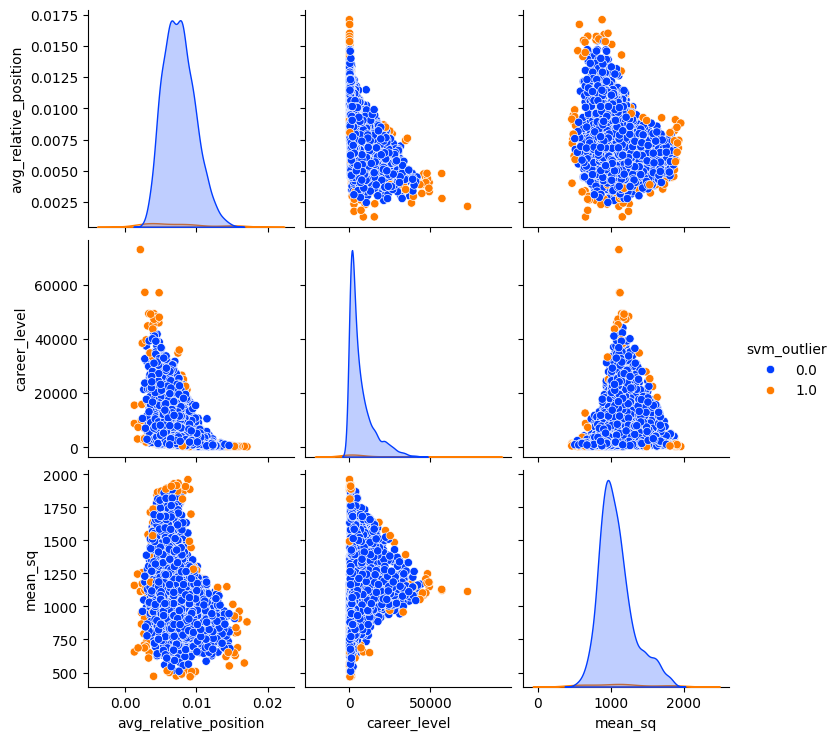

In [62]:
# Classify points as outliers or not
cyclists_with_outlier_score.drop(columns=['svm_degree'], inplace=True)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["svm_outlier"]], hue='svm_outlier', diag_kind='kde', palette='bright')
plt.show()

In [63]:
cyclists_with_outlier_score["svm_outlier"].value_counts()

svm_outlier
0.0    3439
1.0     107
Name: count, dtype: int64

Analyze some of them

In [64]:
outliers = cyclists_with_outlier_score[cyclists_with_outlier_score['svm_outlier'] == 1]
outliers.drop(columns=["svm_outlier"]).head()

,_url,name,birth_year,nationality,cyclist_experience,cyclist_experience_points,cyclist_win,cyclist_win_ratio,avg_relative_position,relative_position_std,...,weighted_podiums,career_level,avg_position,best_position,position_std,mean_sq,top_cyclists,top_experience,lof_degree,connectivity_outlier
54,juan-ayuso-pesquera,Juan Ayuso,2002,Spain,53,3600.0,3,0.056604,0.002646,0.002791,...,7.245283,2994.892723,22.094340,0,21.078848,793.547170,Top 2500,Top 3000,1.084331,0
67,tadej-pogacar,Tadej Pogačar,1998,Slovenia,166,17775.0,30,0.180723,0.001311,0.001727,...,30.903614,15475.414930,14.313253,0,18.713423,1158.957831,Top 500,Top 1300,1.943948,1
118,vincent-lavenu,Vincent Lavenu,1956,France,22,2375.0,0,0.000000,0.004418,0.001894,...,0.000000,1163.520770,73.590909,24,36.460885,1785.590909,Top 3000,Top 3500,1.062442,0
132,davis-phinney,Davis Phinney,1959,United States,77,8200.0,3,0.038961,0.004483,0.003452,...,4.285714,4239.554543,77.870130,0,61.143350,1842.441558,Top 1700,Top 2500,1.156519,0
179,frans-verbeeck,Frans Verbeeck,1941,Belgium,52,11850.0,6,0.115385,0.001308,0.001516,...,74.903846,8730.230122,5.115385,0,4.509919,655.980769,Top 1000,Top 3000,1.532497,1


Analyze how much cyclists has both outlier score positive

In [65]:
outliers = cyclists_with_outlier_score[(cyclists_with_outlier_score['svm_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)]
print(f"In total there are {int(len(outliers))} data with both outlier scores positive\n")


In total there are 37 data with both outlier scores positive



## Isolation forest


**Isolation Forest** is an anomaly detection algorithm that isolates outliers by randomly selecting features and splitting data, with outliers being easier to isolate.

We set **contamination equal** to 2.5% to ensure that the proportion of outliers detected is consistent with other methods, aligning the outlier count.

In [66]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest algorithm with a lower contamination value
isolation_forest = IsolationForest(n_estimators=200, contamination=0.025, n_jobs=-1, random_state=42)
isolation_forest.fit(cyclists_df)

# Compute the outlier scores
outlier_scores = isolation_forest.decision_function(cyclists_df)       # negative values are outliers
outlier_predictions = isolation_forest.predict(cyclists_df)

# Add the outlier scores to the dataframe
cyclists_with_outlier_score['isolation_forest_score'] = outlier_scores
cyclists_with_outlier_score['isolation_forest_outlier'] = (outlier_predictions == -1).astype(int)

print(cyclists_with_outlier_score['isolation_forest_outlier'].value_counts())

isolation_forest_outlier
0    3457
1      89
Name: count, dtype: int64


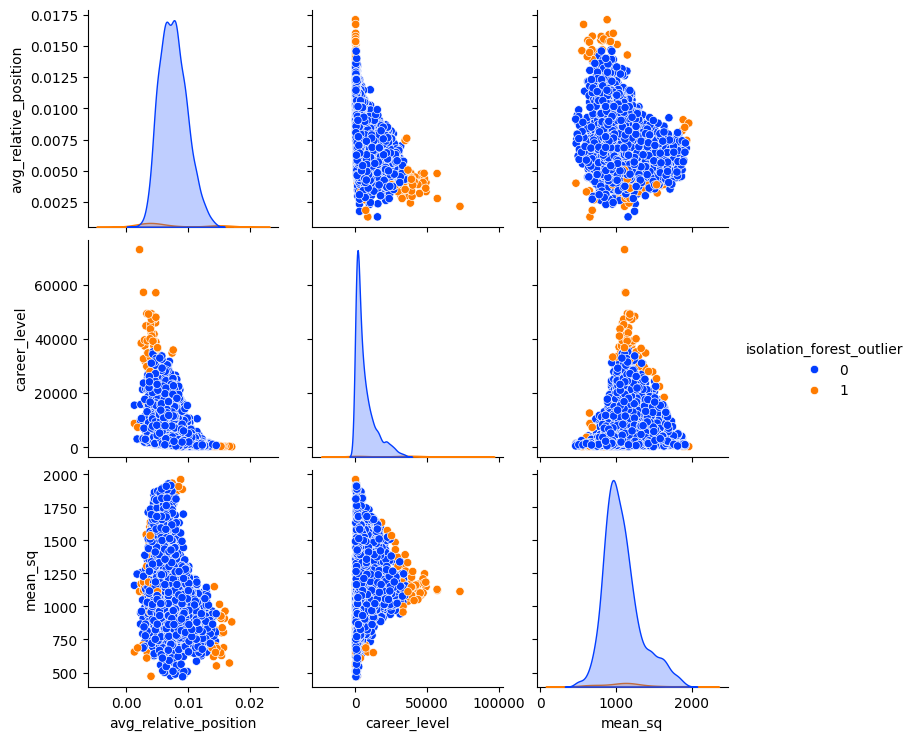

In [67]:
cyclists_with_outlier_score.drop(columns=['isolation_forest_score'], inplace=True)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["isolation_forest_outlier"]], hue="isolation_forest_outlier", diag_kind='kde', palette='bright')
plt.show()

## ENSAMBLING DECISION

Check when at least two outlier score are positive to classify a point as an outlier

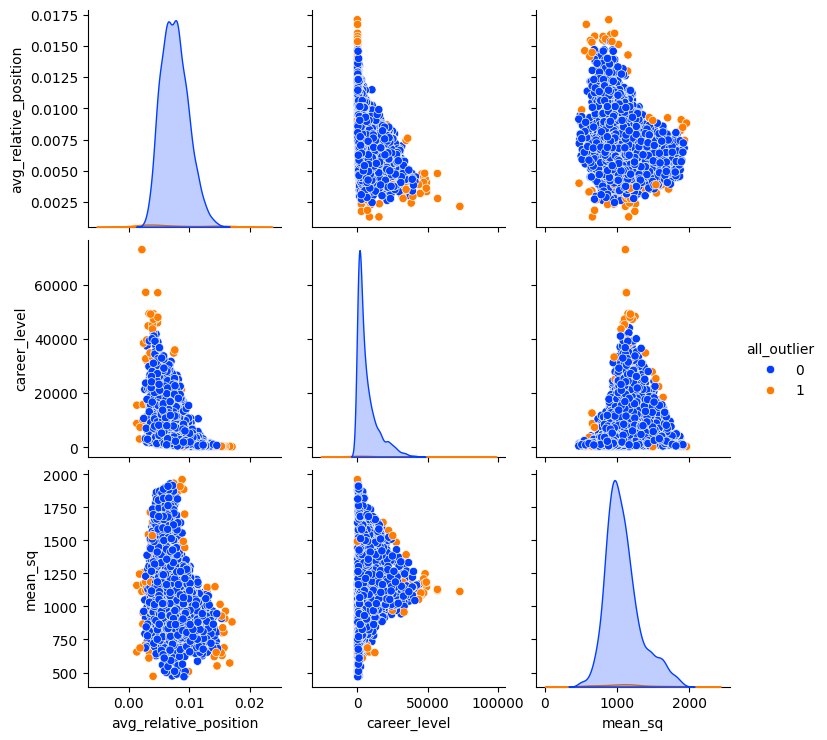

In [68]:
cond1 = (cyclists_with_outlier_score['isolation_forest_outlier'] == 1) & (cyclists_with_outlier_score['svm_outlier'] == 1) 
cond2 = (cyclists_with_outlier_score['isolation_forest_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)
cond3 = (cyclists_with_outlier_score['svm_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)
cond = cond1 | cond2 | cond3

cyclists_with_outlier_score['all_outlier'] = (cond).astype(int)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["all_outlier"]], hue='all_outlier', diag_kind='kde', palette='bright')
plt.show()

Count how many outliers individued by ensambling methods

In [69]:
print(cyclists_with_outlier_score['all_outlier'].value_counts())

all_outlier
0    3476
1      70
Name: count, dtype: int64


### Trying to characterize the outlier

First isolate outliers in a separate df in order to analyze the distribution of removed rows

In [70]:
outlier_df = cyclists_with_outlier_score[cyclist_numeric_columns + ['all_outlier']]
outlier_df = outlier_df[outlier_df['all_outlier'] == 1]

# Normalize the data
normalized_outlier_df = pd.DataFrame(scaler.transform(outlier_df[cyclist_numeric_columns]), columns=cyclist_numeric_columns)

print(outlier_df.describe())

       avg_relative_position  career_level      mean_sq  all_outlier
count              70.000000     70.000000    70.000000         70.0
mean                0.007618  17840.506239  1110.259689          1.0
std                 0.005215  20307.948905   369.194789          0.0
min                 0.001308    145.859629   471.666667          1.0
25%                 0.003345    340.454154   870.837302          1.0
50%                 0.004763   7495.863278  1117.149804          1.0
75%                 0.012973  34743.388074  1235.271289          1.0
max                 0.017087  72883.361014  1959.000000          1.0


From this analysis it seems that this ensambling decision allows to drop cyclists with medium to high average relative position, lower to very higher career level value and same for mean startlist quality column

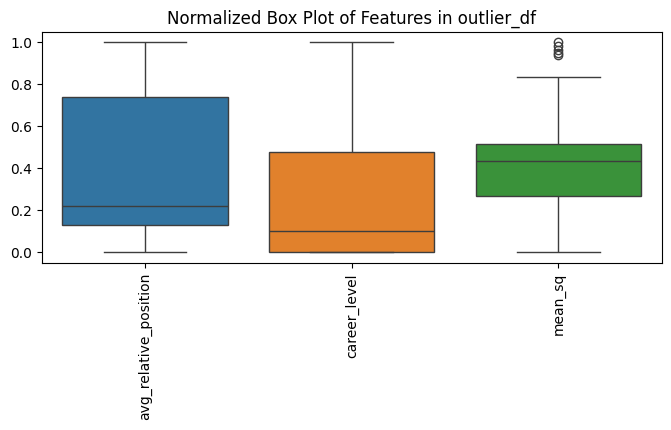

In [71]:
 # Create a box plot
plt.figure(figsize=(8, 3))
sns.boxplot(data=normalized_outlier_df[cyclist_numeric_columns])
plt.xticks(rotation=90)
plt.title('Normalized Box Plot of Features in outlier_df')
plt.show()

### Characterizing remaining rows

Plot distribution of remaining columns after outlier detection

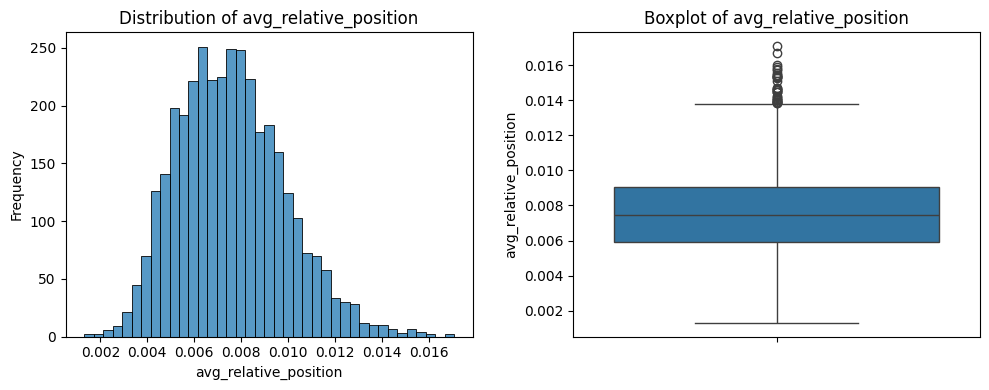

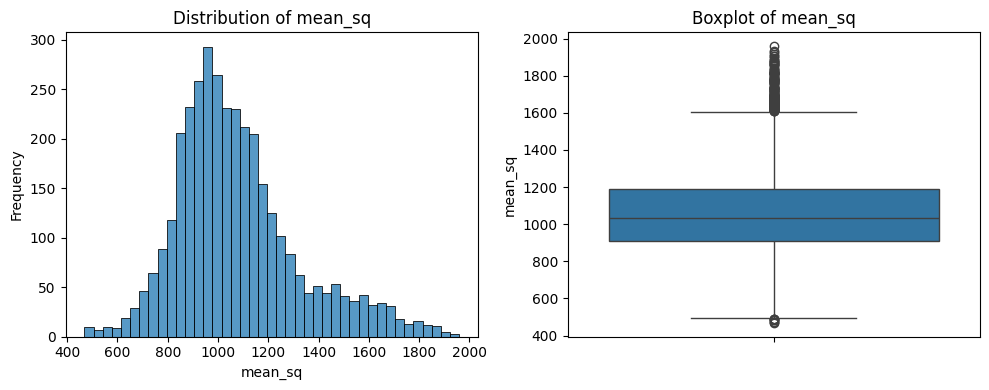

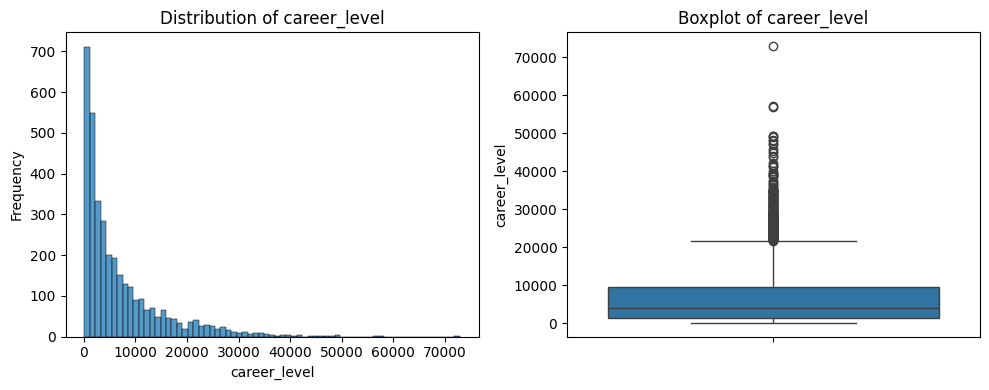

In [72]:
for feature in columns_to_keep:
    plt.figure(figsize=(10, 4))  # Resize the figure
    plt.subplot(1, 2, 1)
    sns.histplot(cyclists_with_outlier_score[feature])
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=cyclists_with_outlier_score[feature])
    plt.title(f'Boxplot of {feature}')
    
    plt.tight_layout()
    plt.show()

After outlier detection we first analyze how many cyclists for each bin in top cyclists column how many cyclists were removed by the algorithm.
recall: top cyclists is a categorical feature that stores cyclists by career level values 

In [73]:
cyclists_with_outlier_score = cyclists_with_outlier_score[cyclists_with_outlier_score['all_outlier'] != 1]
cyclists_with_outlier_score.drop(columns=['connectivity_outlier', 'svm_outlier', 'isolation_forest_outlier' ,'all_outlier', 'lof_degree'], inplace=True)

In [74]:
cyclists_with_outlier_score.value_counts("top_cyclists")

top_cyclists
Rest        517
Top 2500    498
Top 3000    498
Top 1700    400
Top 500     342
Top 2000    299
Top 1300    297
Top 750     249
Top 1000    248
Top 150      96
Top 50       25
Top 20        6
Name: count, dtype: int64

As seen from this analysis, the method removes cyclists from all categories (based on career level value), with the majority of removals occurring in the top 20 and Rest classes.

#### Rescaling ```top_cyclists``` column after outlier detection

In [75]:
# Sort the cyclists_df DataFrame by the 'career_level' column in descending order
sorted_cyclists_df = cyclists_with_outlier_score.sort_values(by='career_level', ascending=False)

# Define the bins and labels
"""bins = [0, 21, 51, 151, 501, 1001, 1501, 2001, 2501, 3001, 3501, len(sorted_cyclists_df)]
labels = ['Top 20', 'Top 50', 'Top 150', 'Top 500', 'Top 1000', 'Top 1501', 'Top 2000', 'Top 2500', 'Top 3000','Top 3500', 'Rest']
"""

# Define the bins and labels
bins = [0, 21, 51, 151, 501, 751, 1001, 1301, 1701, 2001, 2501, 3001, len(sorted_cyclists_df)]
labels = ['Top 20', 'Top 50', 'Top 150', 'Top 500', 'Top 750', 'Top 1000', 'Top 1300', 'Top 1700', 'Top 2000', 'Top 2500', 'Top 3000', 'Rest']

# Create a new column 'career_level_category' based on the bins
sorted_cyclists_df['top_cyclists'] = pd.cut(range(1, len(sorted_cyclists_df) + 1), bins=bins, labels=labels, right=False)

cyclists_with_outlier_score.drop(columns=['top_cyclists'], inplace=True)
# Add the 'top_cyclists' column to the original cyclists_df
cyclists_with_outlier_score = cyclists_with_outlier_score.merge(sorted_cyclists_df[['_url', 'top_cyclists']], on='_url', how='left')


### Scatter plot

Trying to analyizing if in our fetures there's some pattern concerning the career level feature

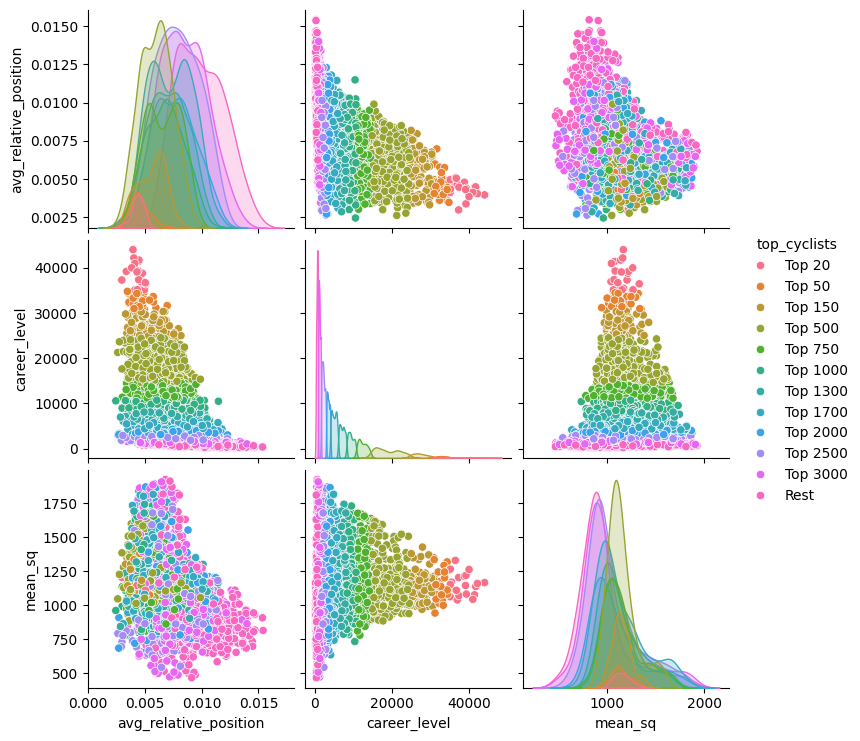

In [24]:
sns.pairplot(cyclists_with_outlier_score.drop(columns=cluster_0_drop), hue='top_cyclists')
plt.show()

### Correlation analysis

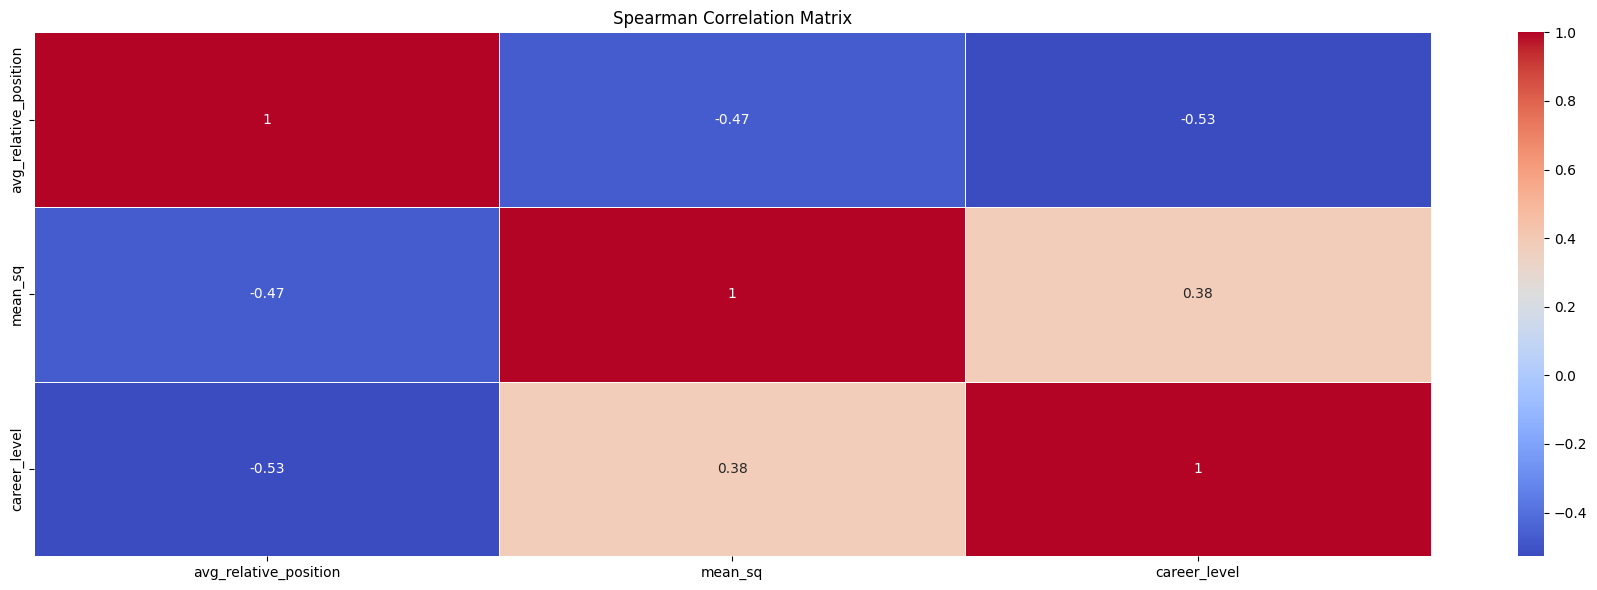

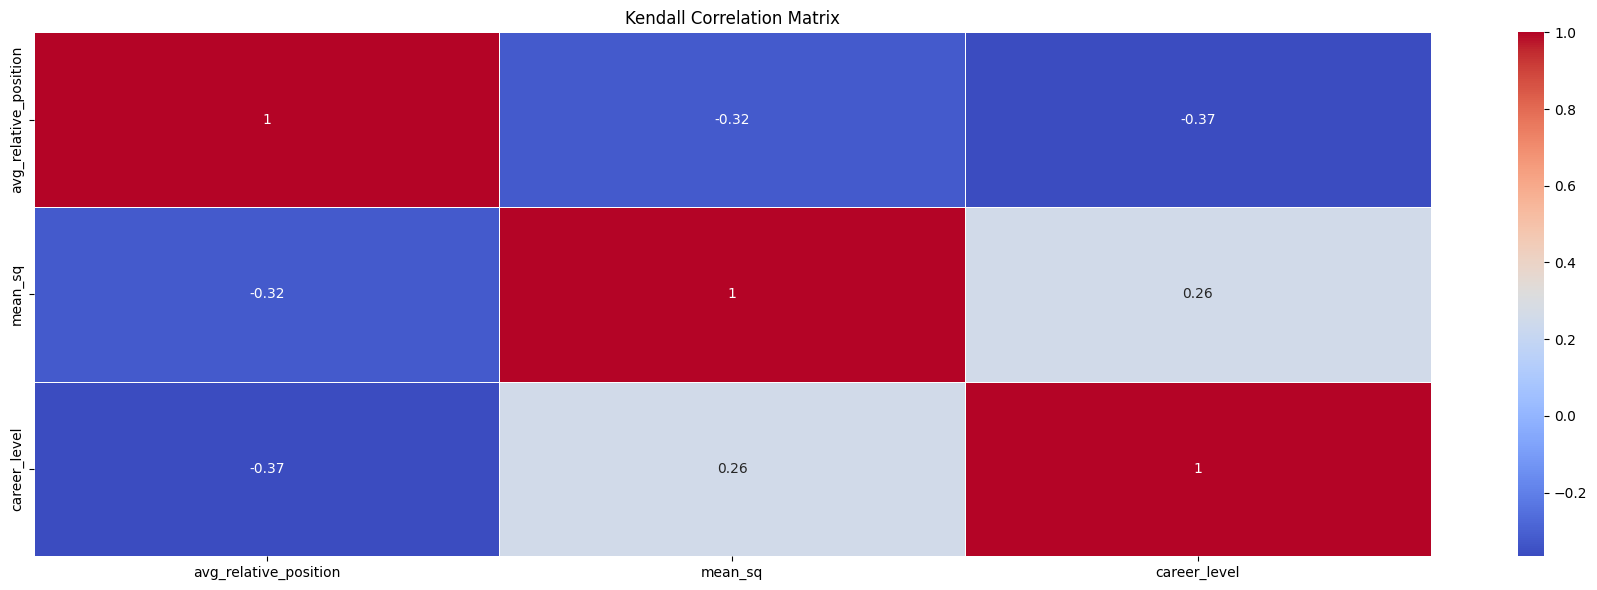

In [25]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

# Now you can import from utils.py
from utils import center_and_scale, correlations, plot_correlations

# Your existing code
normalized_cyclist, normalization_scalers_cyclist = center_and_scale(cyclists_with_outlier_score[columns_to_keep])
cyclists_corr = correlations(normalized_cyclist, ["spearman"])
plot_correlations(cyclists_corr)
normalized_cyclist, normalization_scalers_cyclist = center_and_scale(cyclists_with_outlier_score[columns_to_keep])
cyclists_corr = correlations(normalized_cyclist, ["kendall"])
plot_correlations(cyclists_corr)

As we can observe outlier detection does not affect feature correlations, so we can proceed with clustering

### Saving the dataset

In [26]:
cyclists_with_outlier_score.columns

Index(['_url', 'name', 'birth_year', 'nationality', 'cyclist_experience',
       'cyclist_experience_points', 'cyclist_win', 'cyclist_win_ratio',
       'avg_relative_position', 'relative_position_std',
       'mean_last_20_positions', 'mean_last_20_positions_1',
       'min_relative_position', 'avg_position_vs_startlist',
       'performance_entropy', 'weighted_podiums', 'career_level',
       'avg_position', 'best_position', 'best_position_std', 'mean_sq',
       'top_experience', 'continent', 'top_cyclists'],
      dtype='object')

In [27]:
cyclists_with_outlier_score.to_csv('../dataset/cyclists_outlier.csv', index=False)